In [1]:
import os
import random
import copy
import torchvision
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from dataset_class import FaceMaskDataset

# Import dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image number: 1835
Image shape: torch.Size([3, 224, 224])
Label: 0


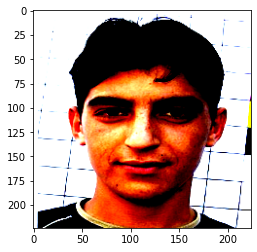

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image number: 3473
Image shape: torch.Size([3, 224, 224])
Label: 1


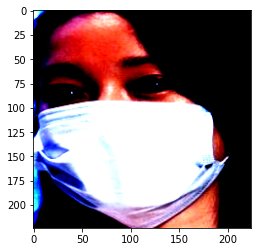

Image number: 835
Image shape: torch.Size([3, 224, 224])
Label: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


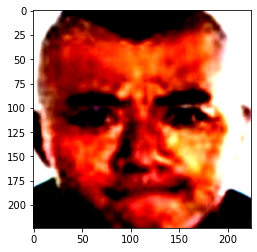

Image number: 4477

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Image shape: torch.Size([3, 224, 224])
Label: 1


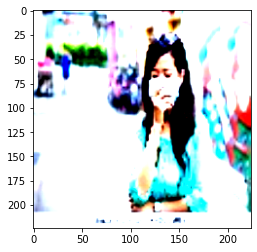

Image number: 2673
Image shape: torch.Size([3, 224, 224])
Label: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


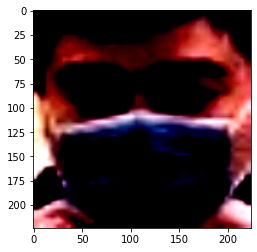

In [2]:
transform_to_tensor = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), 
                                                      torchvision.transforms.ToTensor(),
                                                      torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
face_mask_dataset = FaceMaskDataset(root_dir='dataset', transform=transform_to_tensor)

for i in random.sample(range(0, len(face_mask_dataset)), 5):
    image, label = face_mask_dataset[i]

    print(f'Image number: {i}')
    print(f'Image shape: {image.shape}')
    print(f'Label: {label}')

    fig =  plt.figure()
    plt.imshow(image.permute(1, 2, 0))
    plt.show()

# Train/test split

In [3]:
dataset_indices = list(range(len(face_mask_dataset)))

random.shuffle(dataset_indices)
train_split_indices = dataset_indices[:int(len(dataset_indices)*0.5)]  
valid_split_indices = dataset_indices[int(len(dataset_indices)*0.5):] 

train_subset_sampler = torch.utils.data.SubsetRandomSampler(train_split_indices)
valid_subset_sampler = torch.utils.data.SubsetRandomSampler(valid_split_indices)
batch_size = 32
num_workers = 8

train_dataloader = torch.utils.data.DataLoader(dataset=face_mask_dataset, batch_size=batch_size, sampler=train_subset_sampler, num_workers=num_workers)
valid_dataloader = torch.utils.data.DataLoader(dataset=face_mask_dataset, batch_size=batch_size, sampler=valid_subset_sampler, num_workers=num_workers)

dataloaders = {'train': train_dataloader, 'val': valid_dataloader}
dataset_sizes = {'train': len(train_subset_sampler), 'val': len(valid_subset_sampler)}

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Define and train model

In [5]:
def plot_accuracy_los(train_accuracy, train_loss, val_accuracy, val_loss, epochs, name=None):
    plt.style.use("ggplot")
    plt.figure()
    
    plt.plot(np.arange(0, epochs), train_loss, label="train_loss")
    plt.plot(np.arange(0, epochs), val_loss, label="val_loss")
    plt.plot(np.arange(0, epochs), train_accuracy, label="train_acc")
    plt.plot(np.arange(0, epochs), val_accuracy, label="val_acc")
    
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    
    if name != None:
        plt.savefig(name + '.png')

In [6]:
def train_model(model, criterion, optimizer, num_epochs):
    start_time = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0
    
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 50)

        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[mode]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(mode == 'train'):
                    outputs = model(inputs)
                    
                    outputs = torch.log_softmax(outputs, -1)
                    
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training mode
                    if mode == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()

            epoch_loss = running_loss / dataset_sizes[mode]
            epoch_acc = float(running_corrects) / dataset_sizes[mode]
            
            if mode == 'train':
                train_accuracy.append(epoch_acc)
                train_loss.append(epoch_loss)
            else:
                val_accuracy.append(epoch_acc)
                val_loss.append(epoch_loss)

            print(f'{mode} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model
            if mode == 'val' and epoch_acc > best_accuracy:
                best_accuracy = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - start_time
    print(f'Training complete in {(time_elapsed // 60):.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_accuracy:4f}')
    
    name = input('Enter image file name:')
    plot_accuracy_los(train_accuracy, train_loss, val_accuracy, val_loss, num_epochs, name)

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Epoch 0/9
--------------------------------------------------
train Loss: 0.4829 Acc: 0.7623
val Loss: 0.2797 Acc: 0.9101

Epoch 1/9
--------------------------------------------------
train Loss: 0.3278 Acc: 0.8673
val Loss: 0.2198 Acc: 0.9449

Epoch 2/9
--------------------------------------------------
train Loss: 0.2844 Acc: 0.8893
val Loss: 0.1835 Acc: 0.9427

Epoch 3/9
--------------------------------------------------
train Loss: 0.2795 Acc: 0.8827
val Loss: 0.1656 Acc: 0.9599

Epoch 4/9
--------------------------------------------------
train Loss: 0.2754 Acc: 0.8889
val Loss: 0.1617 Acc: 0.9444

Epoch 5/9
--------------------------------------------------
train Loss: 0.2381 Acc: 0.9123
val Loss: 0.1395 Acc: 0.9621

Epoch 6/9
--------------------------------------------------
train Loss: 0.2411 Acc: 0.9074
val Loss: 0.1386 Acc: 0.9638

Epoch 7/9
--------------------------------------------------
train Loss: 0.2445 Acc: 0.9026
val Loss: 0.1319 Acc: 0.9630

Epoch 8/9
--------------

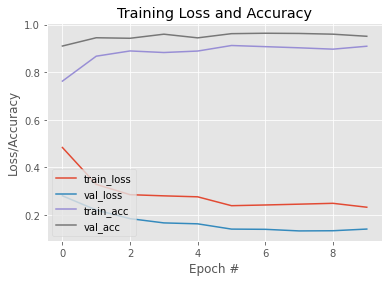

In [7]:
model_name = 'inception_v3' # can be 'resnet50' and 'inception_v3'

if model_name == 'resnet50':
    model = torchvision.models.resnet50(pretrained=True)
elif model_name == 'inception_v3':
    model = torchvision.models.inception_v3(pretrained=True)
    model.aux_logits=False

# do not update pretrained weights
for param in model.parameters():
    param.requires_grad = False
    
finetuned_model = copy.deepcopy(model)

num_ftrs = finetuned_model.fc.in_features
finetuned_model.fc = nn.Sequential(nn.Dropout(0.5), nn.Linear(num_ftrs, 2))

finetuned_model = finetuned_model.to(device) 

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, finetuned_model.parameters()))

num_epochs = 10

# change num_epochs to smaller number for faster iteration
best_model = train_model(finetuned_model, criterion, optimizer, num_epochs)  

In [8]:
torch.save(best_model, 'models/inception_normalized_50_50_with_augmentation093845.pt')
# best_model = torch.load('models/inception_normalized_50_50_without_augmented0956978.pt')
# print(best_model)

# Visualize model output

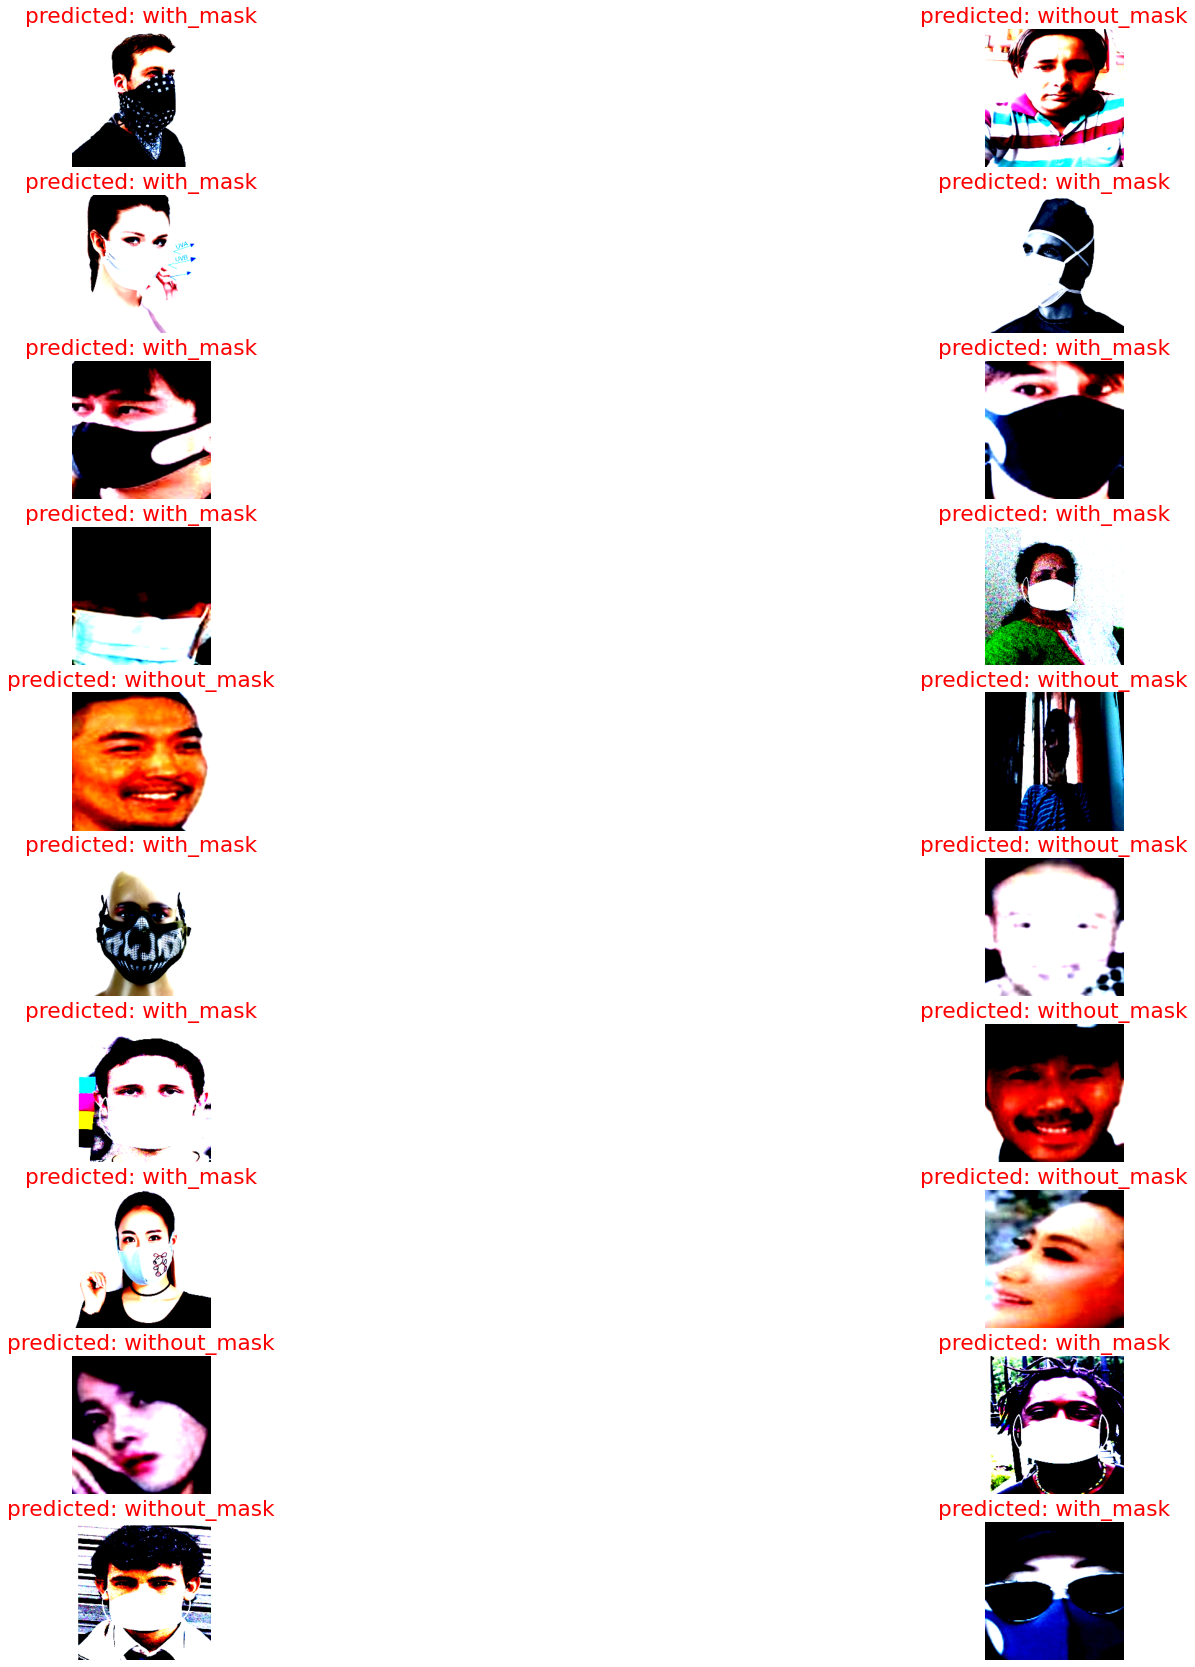

In [9]:
def visualize_model(model, num_images=20):
    model.eval()
    model = model.to(device)
    
    images_so_far = 0
    fig = plt.figure(figsize=(30, 30))
    
    params = {'text.color': 'red', 'font.size': 15}
    plt.rcParams.update(params)

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            
            outputs = torch.softmax(outputs, -1)
            
            tmp, preds = torch.max(outputs, 1)

            for i in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(face_mask_dataset.class_names[preds[i]]))
                
                img = inputs.cpu().data[i].numpy().transpose((1, 2, 0))
                img = np.clip(img, 0, 1)  

                plt.imshow(img)

                if images_so_far == num_images:
                    return
            
            plt.show()
            
            
visualize_model(best_model)

# Evaluate model

71it [04:22,  3.69s/it]


Evaluate model on validation set


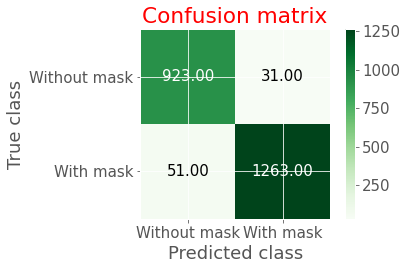

Accuracy: 0.9638447971781305
Precision(with mask): 0.9760432766615147
Recall(with mask): 0.9611872146118722
F1: 0.968558282208589


In [13]:
from evaluation import evaluate_model

best_model.cpu()
best_model.eval()

all_val_labels = []
all_val_pred = []
all_probabilities = []

with torch.no_grad():
    for i, (inputs, labels) in tqdm(enumerate(dataloaders['val'])):
        outputs = best_model(inputs)

        outputs = torch.log_softmax(outputs, -1)

        if i == 0: 
            all_probabilities = outputs
        else:
            all_probabilities = np.concatenate((all_probabilities, outputs.numpy()), axis=0)

        _, preds = torch.max(outputs, 1)

        all_val_labels = np.concatenate((all_val_labels, labels.numpy()), axis=None)
        all_val_pred = np.concatenate((all_val_pred, preds.numpy()), axis=None)

evaluate_model(all_val_labels, all_val_pred, all_probabilities[1], 'Evaluate model on validation set')

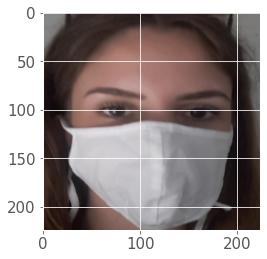

Predicted class: with_mask


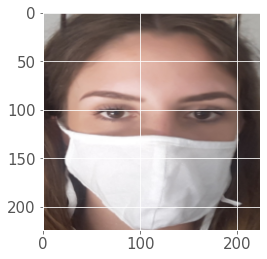

Predicted class: with_mask


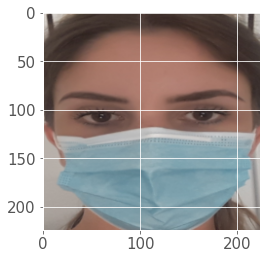

Predicted class: with_mask


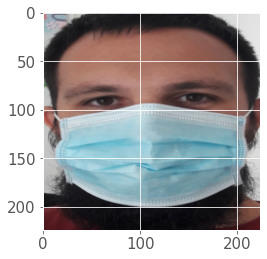

Predicted class: with_mask


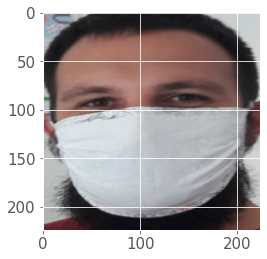

Predicted class: with_mask


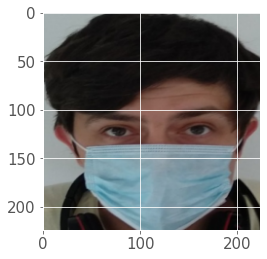

Predicted class: with_mask


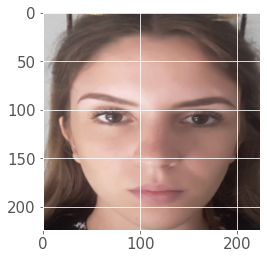

Predicted class: without_mask


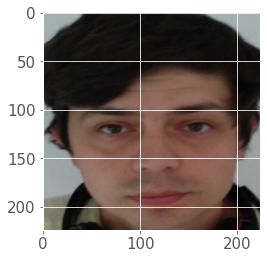

Predicted class: without_mask


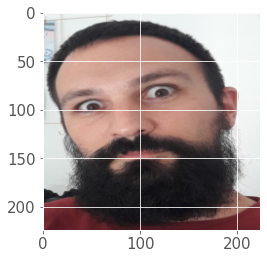

Predicted class: without_mask


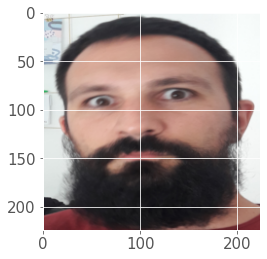

Predicted class: without_mask


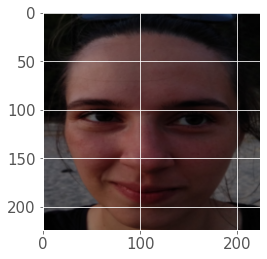

Predicted class: without_mask


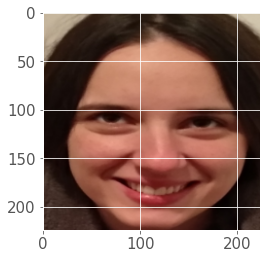

Predicted class: without_mask


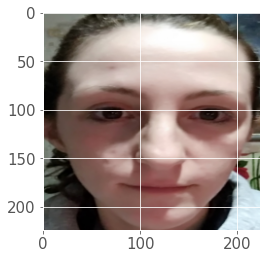

Predicted class: without_mask


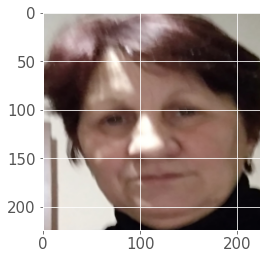

Predicted class: with_mask


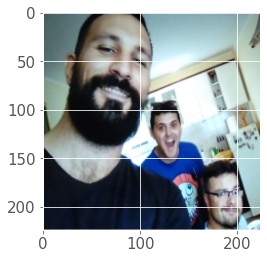

Predicted class: without_mask


In [26]:
from PIL import Image
from imutils import paths


best_model.cpu()
paths = list(paths.list_images('MI'))
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), 
                                            torchvision.transforms.ToTensor()])

fig =  plt.figure()

for path in paths:
    image = Image.open(path).convert("RGB")
    image = transform(image)
    img = image.unsqueeze(0)

    output = best_model(img)
    _, predicted = torch.max(output, 1)
    
    plt.imshow(image.permute(1, 2, 0))
    plt.show()
    
    print(f'Predicted class: {face_mask_dataset.class_names[predicted[0]]}')